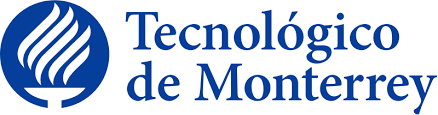

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Proyecto Integrador**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Modelo Final Topic Extraction**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


## **Libraries to install**

In [ ]:
!pip install spacy # Library necesary for Tokenization tool
!pip install wordcloud # Library for wordcloud
!pip install datasets # Library Necesary for Datasets manipulation.
!pip install gensim --upgrade --user #library necesary to perform LDI
!pip install pyLDAvis==2.1.2

## **Libraries to be used**

In [ ]:
# Data Analysis.
import pandas as pd
import numpy as np
import nltk
#library to use spacy for tokenization
import spacy

# Library to make plots
import seaborn as sns
import matplotlib.pyplot as plt

#library for Regex
import re
import unicodedata
# Dataset manipulation.
from datasets import Dataset, load_dataset, DatasetDict, load_metric

## Libraries for  Wordcloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

## TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## (Truncated Singular Value Decomposition, Truncated SVD)
from sklearn.decomposition import TruncatedSVD

# LSI with Gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

#Gensim's ldamulticore, which takes advantage of the processing power of multiple CPU cores.
from gensim.models.ldamulticore import LdaMulticore
from multiprocessing import cpu_count

# Visualization using pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from IPython.display import display, HTML


# **Load Data from Github**

In [ ]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments.csv'
data= pd.read_csv(url)
data

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


# **EDA - Exploratory Data Analysis**

## **1- Elimination of nan rows.**

Since in the data extraction some reviews no rated, in these reviews the label was added **nan** , the first thing we must do is eliminate the data that does not have a label.

In [ ]:
nan_data = data.isna()
print(nan_data)

      Review  Stars
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
1658   False   True
1659   False   True
1660   False   True
1661   False   True
1662   False   True

[1663 rows x 2 columns]


In [ ]:
data_clean= data.dropna(subset=['Stars']) # dropna will eliminate nan reviews. (reviews not rated)
data_clean=data_clean.reset_index(drop=True) #restar index
data_clean

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,1.0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,1.0
961,"I purchased a 2011 Grand Cherokee in July, 201...",2.0
962,I have a 2003 Jeep Grand Cherokee and have had...,1.0


## **2- Creation of binary label.**

Convert the rates scale (1,2,3,4,5) to binary problem (0,1)

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case let's decide to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

In [ ]:
ds = Dataset.from_dict({"text": data_clean.Review, "labels": [1 if star >= 4 else 0 for star in data_clean.Stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 964
})

In [ ]:
ds.to_pandas()

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


In [ ]:
labels_1 = ds.to_pandas()[ds.to_pandas().labels== 1]
labels_0 = ds.to_pandas()[ds.to_pandas().labels== 0]

In [ ]:
# Calculate the ratio of positive and negative tags
label_count = ds.to_pandas().labels.value_counts()
proportion_negative, proportion_positive = (label_count/len(ds['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.13
% of negative comments: 0.87


In [ ]:
label_count

0    841
1    123
Name: labels, dtype: int64

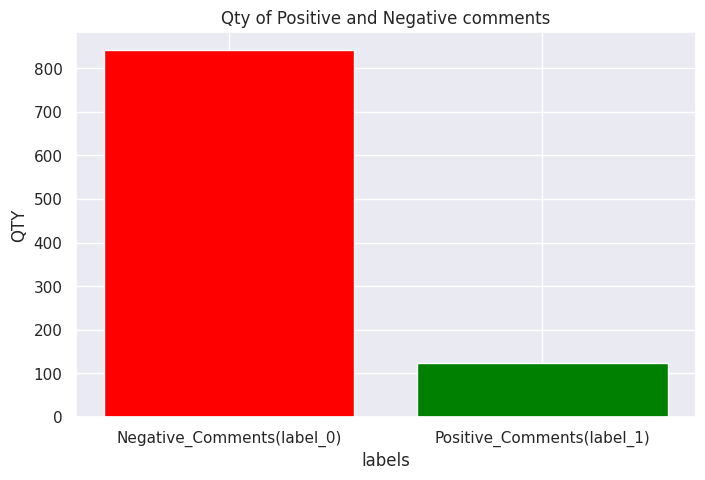

In [ ]:
# Plot the proportions
labels = ['Negative_Comments(label_0)', 'Positive_Comments(label_1)']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['red', 'green'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('Qty of Positive and Negative comments')
plt.show()

## **Labels division**


In [ ]:
labels_1

,text,labels
19,My Grand Cherokee is one of the best vehicles ...,1
21,I currently own two Jeep vehicles. One I purch...,1
24,I've now owned five Jeeps. Two Grand Cherokees...,1
27,I have owned several Jeeps. Affordable 4 wheel...,1
41,This vehicle is a great medium size SUV. Bough...,1
...,...,...
835,Had a 97 that I still miss. I hate that Jeep u...,1
840,My 2007 Jeep Grand Cherokee has started stalli...,1
948,I get about one phone call a month from a Jeep...,1
950,"On Wednesday November 23, 2011, I was pulling ...",1


In [ ]:
labels_0

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


# **Data Processing**

## **Data Cleaning**

##**Function to clean data with regex**

In [ ]:

def clean_doc(doc):

    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Con REGEX reemplazamos por espacio todo aquello que no es letra o espacio dejando solo caracteres alfabéticos
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    # Con REGEX reemplazamos todos aquellos espacios dobles o mayores por espacios simples
    doc = re.sub(r'\s{2,}', ' ', doc)
    # Simplificamos todo a minúsculas
    doc = doc.lower()

    return doc


In [ ]:
cleaned_docs_label_0 = [clean_doc(row.text) for row in labels_0.itertuples()]
cleaned_docs_label_1=[clean_doc(row.text) for row in labels_1.itertuples()]

##**Function to tokenize corpus with Spacy**

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['textcat'])
print(nlp.pipe_names)

def tokenize(corpus):

    docs = nlp.pipe(corpus)#, n_process=4, batch_size=1000)
    tokens = []

    for doc in docs:
        tokens.append([word.lemma_ for word in doc if word.is_stop == False and len(word.text) > 1])

    return tokens

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [ ]:
tokens_label_0  = tokenize(cleaned_docs_label_0)
tokens_label_1  = tokenize(cleaned_docs_label_1)

In [ ]:
for x in tokens_label_0[0:5]:
  print(x)

['hour', 'not', 'reach', 'tell', 'phone', 'block', 'number', 'block', 'spam', 'blocker', 'day', 'practically', 'beg', 'help', 'cancel', 'uconnect', 'service', 'way', 'immediately', 'bill', 'monthly', 'pay', 'day', 'use', 'service']
['go', 'replace', 'hose', 'radiator', 'outlet', 'week', 'ago', 'compass', 'tailhawk', 'available', 'go', 'create', 'specifically', 'jeep', 'decency', 'available', 'know', 'happen', 'plastic', 'engine', 'course', 'go', 'melt', 've', 'jeep', 'lover', 'life', 'probably', 'purchase', 'long', 'customer', 'mind', 'create', 'company', 'let', 'create', 'purchase', 'manufacturer', 'inventory', 'ongoing', 'problem', 'go', 'to', 'month', 'ready', 'expect', 'people', 'function', 'able', 'work', 'mean', 'transportation', 'curious', 'number', 'garage', 'take', 'jeep', 'say', 'ford', 'jeep', 'business', 'problem', 'arise', 'stop', 'go', 'dealership', 'service', 'center', 'year', 'ago', 'good', 'experience', 've', 'different', 'state', 'result', 'internally', 'need', 'fix',

In [ ]:
print("Qty of tokens of comments negative:",len(tokens_label_0))
print("Qty of tokens of comments positive:",len(tokens_label_1))

Qty of tokens of comments negative: 841
Qty of tokens of comments positive: 123


## **Elimination of empty spaces**

In [ ]:
# Empty spaces elimination
tokens_label_0 = list(filter(None, tokens_label_0))
print(len(tokens_label_0))
tokens_label_1 = list(filter(None, tokens_label_1))
print(len(tokens_label_1))

841
123


## **Vocabulary Creation**

In [ ]:
from collections import Counter

vocab_label_0 = Counter() #Vocabulary negative comments.
vocab_label_1 = Counter() #Vocabulary positive comments.

for k in range(len(tokens_label_0)):
 vocab_label_0.update(tokens_label_0[k])

print('Vobulary length of negative comments:', len(vocab_label_0))
print('(word,frequency):')
print(vocab_label_0.most_common(10))

for k in range(len(tokens_label_1)):
 vocab_label_1.update(tokens_label_1[k])

print('\nVobulary length of postitive comments:', len(vocab_label_1))
print('(word,frequency):')
print(vocab_label_1.most_common(10))


Vobulary length of negative comments: 5313
(word,frequency):
[('jeep', 2720), ('car', 1294), ('vehicle', 950), ('problem', 784), ('time', 778), ('drive', 702), ('tell', 690), ('dealership', 663), ('chrysler', 612), ('buy', 597)]

Vobulary length of postitive comments: 1296
(word,frequency):
[('jeep', 214), ('vehicle', 80), ('car', 77), ('drive', 76), ('great', 70), ('like', 61), ('good', 59), ('love', 50), ('seat', 48), ('cherokee', 40)]


### **Elimination of words with frequency lower than min_freq**

In [ ]:
min_freq = 2

mydicc_label_0 = {k: v for k, v in vocab_label_0.items() if v >= min_freq}
mydicc_label_1 = {k: v for k, v in vocab_label_1.items() if v >= min_freq}

print('New vocabulary length of negative comments:', len(mydicc_label_0))
print(list(mydicc_label_0.items())[0:5])

print('New vocabulary length of positive comments:', len(mydicc_label_1))
print(list(mydicc_label_1.items())[0:5])

New vocabulary length of negative comments: 3074
[('hour', 136), ('not', 117), ('reach', 22), ('tell', 690), ('phone', 87)]
New vocabulary length of positive comments: 618
[('grand', 28), ('cherokee', 40), ('good', 59), ('vehicle', 80), ('ve', 25)]


### **Vocabulary convertion as list**

In [ ]:
myvocab_label_0 = list(mydicc_label_0.keys())
myvocab_label_1 = list(mydicc_label_1.keys())

## **Sentence creation**

In [ ]:
sentences_label_0 = [" ".join(x) for x in tokens_label_0]
print("Qty of sentences for Negative Comments:",len(sentences_label_0))

sentences_label_1 = [" ".join(x) for x in tokens_label_1]
print("Qty of sentences for Positive Comments:",len(sentences_label_1))

Qty of sentences for Negative Comments: 841
Qty of sentences for Positive Comments: 123


## **World Cloud Visualization.**

In [ ]:
wc_text_label_0= ''
wc_text_label_1= ''

for token in tokens_label_0:

  wc_text_label_0 = wc_text_label_0 +" " + " ".join(token)

wc_label_0 = WordCloud(background_color='white').generate(wc_text_label_0)

for token in tokens_label_1:

  wc_text_label_1 = wc_text_label_1 +" " + " ".join(token)

wc_label_1 = WordCloud(background_color='white').generate(wc_text_label_1)

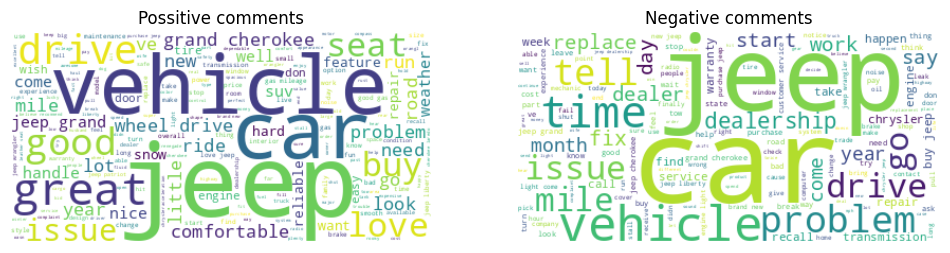

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# Positive feedback word cloud:
ax1.imshow(wc_label_1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Possitive comments')

# Negative comments word cloud:
ax2.imshow(wc_label_0, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Negative comments')

plt.show()

## **TF-IDF Vectorizer**

In [ ]:
tfidf_label_0 = TfidfVectorizer(smooth_idf=True, vocabulary=myvocab_label_0)
tfidf_label_1 = TfidfVectorizer(smooth_idf=True, vocabulary=myvocab_label_1)
vector_label_0 =tfidf_label_0.fit_transform(sentences_label_0)
vector_label_1 =tfidf_label_1.fit_transform(sentences_label_1)
X_label_0 = vector_label_0.toarray()
X_label_1 = vector_label_1.toarray()

df_tfidfvect_label_0 = pd.DataFrame(
    data=X_label_0,
    columns=tfidf_label_0.get_feature_names_out()
)
print("TF-IDF negative comments:\n",df_tfidfvect_label_0[0:5])


df_tfidfvect_label_1 = pd.DataFrame(
    data=X_label_1,
    columns=tfidf_label_1.get_feature_names_out()
)
print("\nTF-IDF postitive comments:\n",df_tfidfvect_label_1[0:5])


TF-IDF negative comments:
        hour       not     reach      tell     phone     block    number  \
0  0.139466  0.160135  0.202301  0.082204  0.155282  0.454782  0.155282   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.090055   
2  0.000000  0.000000  0.000000  0.057420  0.000000  0.000000  0.000000   
3  0.000000  0.033722  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.175515  0.000000  0.000000  0.000000  0.000000  0.000000   

       spam       day  practically  ...  nut  jose  clause  mil  pajero  \
0  0.291874  0.197613     0.261393  ...  0.0   0.0     0.0  0.0     0.0   
1  0.000000  0.000000     0.000000  ...  0.0   0.0     0.0  0.0     0.0   
2  0.000000  0.000000     0.000000  ...  0.0   0.0     0.0  0.0     0.0   
3  0.000000  0.062422     0.055046  ...  0.0   0.0     0.0  0.0     0.0   
4  0.000000  0.000000     0.000000  ...  0.0   0.0     0.0  0.0     0.0   

   incline  utility  bye  miami  conveyor  
0      0.0      0.0  0.0   

# **Topic Extraction algoriths**

## **LSI (Latent Semantic Indexing)**

Latent Semantic Indexing (LSI) is a mathematical technique used in natural language processing and information retrieval to analyze the relationships between a set of documents and the terms they contain. It's based on the principle that words that are used in similar contexts tend to have similar meanings.

LSI works by constructing a mathematical representation of the relationships between terms and documents in a high-dimensional space. This representation allows for the detection of latent (hidden) semantic structure within the text. By reducing the dimensionality of this space, LSI can identify the underlying concepts or topics present in the documents.

LSI is commonly used in tasks such as document classification, information retrieval, and document summarization. It helps improve the accuracy and relevance of search results by capturing the semantic meaning of terms and documents, rather than relying solely on exact keyword matches.

### **LSI (Latent Semantic Indexing) method using SVD**

TruncatedSVD is a class in the scikit-learn library used to perform Truncated Singular Value Decomposition (Truncated SVD). Singular Value Decomposition (SVD) is a common technique in linear algebra and data analysis for dimensionality reduction.

In particular, TruncatedSVD implements an efficient version of SVD that truncates (limits) the number of components to be computed. This makes it useful for working with high-dimensional data matrices where the number of features is large and we want to efficiently reduce that dimensionality.

Some common uses of TruncatedSVD include:

- Dimensionality reduction: It allows reducing the dimensionality of a dataset while retaining the most important or explanatory features.

- Feature extraction: It can be used to extract significant features from a dataset, especially in high-dimensional datasets.

- Data compression: It can be used to compress data by reducing its dimensionality while preserving as much information as possible.


In [ ]:
svd_model_label_0 = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
svd_model_label_1 = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
svd_model_label_0.fit(X_label_0)
svd_model_label_1.fit(X_label_1)
print("No. Componentes of Negative comments",len(svd_model_label_0.components_))
print("No. Componentes of Positive comments",len(svd_model_label_1.components_))

No. Componentes of Negative comments 10
No. Componentes of Positive comments 10


In [ ]:
# Singular Values
sigmas_label_0 = svd_model_label_0.singular_values_
sigmas_label_1 = svd_model_label_1.singular_values_

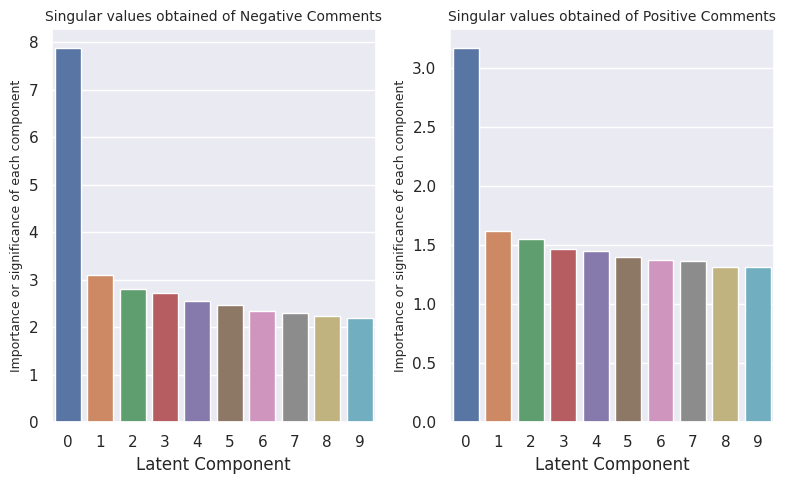

In [ ]:
# Set the figure size
sns.set(rc={'figure.figsize': (8, 5)})  # Adjusted width to accommodate two plots side by side

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2)

colors_0 = sns.color_palette('deep', len(sigmas_label_0))
colors_1 = sns.color_palette('deep', len(sigmas_label_1))

# Plot for  impoartance of each component for negative comments
sns.barplot(x=list(range(len(sigmas_label_0))), y=sigmas_label_0,hue=list(range(len(sigmas_label_0))), ax=axes[0],palette=colors_0, legend=False)
axes[0].set_title('Singular values obtained of Negative Comments',fontdict = {'size': 10})
axes[0].set_xlabel('Latent Component')
axes[0].set_ylabel('Importance or significance of each component',fontdict = {'size': 9})

# Plot for  impoartance of each component for positive comments
sns.barplot(x=list(range(len(sigmas_label_1))), y=sigmas_label_1,hue=list(range(len(sigmas_label_0))), ax=axes[1],palette=colors_1, legend=False)
axes[1].set_title('Singular values obtained of Positive Comments',fontdict = {'size': 10})
axes[1].set_xlabel('Latent Component')
axes[1].set_ylabel('Importance or significance of each component',fontdict = {'size': 9})

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### **Transposition of svd_model.components**

In [ ]:

lsi_term_topic_label_0 = svd_model_label_0.components_.T
lsi_term_topic_label_1 = svd_model_label_1.components_.T
print("LSI Term matrix size for negative comments:",lsi_term_topic_label_0.shape)
print("LSI Term matrix size for positive comments:",lsi_term_topic_label_1.shape)

LSI Term matrix size for negative comments: (3074, 10)
LSI Term matrix size for positive comments: (618, 10)


In [ ]:
# Terms names for negative comments
terms_names_label_0 = list(tfidf_label_0.get_feature_names_out())
print("Terms names for negative comments:",terms_names_label_0[0:10])
# Terms names for positive comments
terms_names_label_1 = list(tfidf_label_1.get_feature_names_out())
print("Terms names for positive comments:",terms_names_label_1[0:10])

Terms names for negative comments: ['hour', 'not', 'reach', 'tell', 'phone', 'block', 'number', 'spam', 'day', 'practically']
Terms names for positive comments: ['grand', 'cherokee', 'good', 'vehicle', 've', 'seat', 'lot', 'well', 'far', 'comfort']


#### **Term_topic_matrix**

In [ ]:
# term_topic_matrix_ negative comments
term_topic_matrix_label_0 = pd.DataFrame(
    data = lsi_term_topic_label_0,
    index = terms_names_label_0,
    columns = [f'Concept_Latent_{i}' for i in range (0, lsi_term_topic_label_0.shape[1])])
term_topic_matrix_label_0.head()

,Concept_Latent_0,Concept_Latent_1,Concept_Latent_2,Concept_Latent_3,Concept_Latent_4,Concept_Latent_5,Concept_Latent_6,Concept_Latent_7,Concept_Latent_8,Concept_Latent_9
hour,0.041523,-0.039722,0.000192,0.027663,-0.013025,-0.022257,0.048480,0.005072,-0.005151,-0.020726
not,0.045367,-0.025983,-0.040757,0.035419,0.067813,-0.010558,0.030391,0.002580,-0.063840,-0.044992
reach,0.009118,-0.001191,-0.017454,0.008168,-0.013366,0.002286,0.006027,-0.014533,-0.003882,-0.020082
tell,0.132197,-0.023847,-0.129898,0.047948,-0.019235,-0.039565,0.107883,-0.054927,0.032407,-0.068185
phone,0.025638,-0.021520,-0.051224,0.034500,-0.008244,-0.031977,-0.002441,-0.005426,-0.039680,-0.049220


In [ ]:
# term_topic_matrix_ negative comments
term_topic_matrix_label_1 = pd.DataFrame(
    data = lsi_term_topic_label_1,
    index = terms_names_label_1,
    columns = [f'Concept_Latent_{i}' for i in range (0, lsi_term_topic_label_1.shape[1])])
term_topic_matrix_label_1.head()

,Concept_Latent_0,Concept_Latent_1,Concept_Latent_2,Concept_Latent_3,Concept_Latent_4,Concept_Latent_5,Concept_Latent_6,Concept_Latent_7,Concept_Latent_8,Concept_Latent_9
grand,0.092995,0.008041,0.104464,-0.140749,-0.123850,-0.070695,0.041009,-0.046438,0.175898,-0.034637
cherokee,0.123842,-0.021833,0.101335,-0.151765,-0.126671,-0.119017,0.082992,-0.018647,0.233651,-0.073435
good,0.209080,-0.172551,-0.324290,0.073945,0.010990,0.198280,0.282939,0.159237,0.201534,-0.050504
vehicle,0.198314,-0.050245,0.148847,-0.106096,0.086188,-0.065004,0.258440,-0.195520,-0.026411,-0.071185
ve,0.105067,0.144460,0.033750,-0.042470,0.123601,0.161068,0.006518,-0.035472,0.169814,-0.106321


#### **Plot Best Latent Concept terms /Tokens**

In [ ]:
def plot_grouped_top_terms(term_topic_matrix, top=10, num_rows=2):
    num_cols = int(top / num_rows)  # Calcular el número de columnas en función del número de filas

    colors_0 = sns.color_palette('deep', top)
    # Split data into top size groups
    grouped_cols = [term_topic_matrix.columns[i:i+top] for i in range(0, len(term_topic_matrix.columns), top)]

    for cols in grouped_cols:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))  # Set up subplots with calculated number of columns
        axes = axes.flatten()  # Flatten the array of subplots to facilitate iteration
        for i, col in enumerate(cols):
            data = term_topic_matrix[col].sort_values(ascending=False)
            top_terms = data[:top]

            sns.barplot(x=top_terms, y=top_terms.index, ax=axes[i],hue=top_terms.index, palette=colors_0)  # Use the current axis (axes[i]) for each graph
            axes[i].set_title(f'Best Latent Concept terms/tokens #{col}', fontdict={'size': 9})
            axes[i].set_xlabel('Frequency', fontdict={'size': 9})
            axes[i].set_ylabel('Terms', fontdict={'size': 9})

        # Eliminate unused subplots if the number of columns is less than the total number of subplots
        for j in range(len(cols), num_rows * num_cols):
            fig.delaxes(axes[j])

        plt.tight_layout()  # Adjust the layout of subplots
        plt.show()

Negative Comment


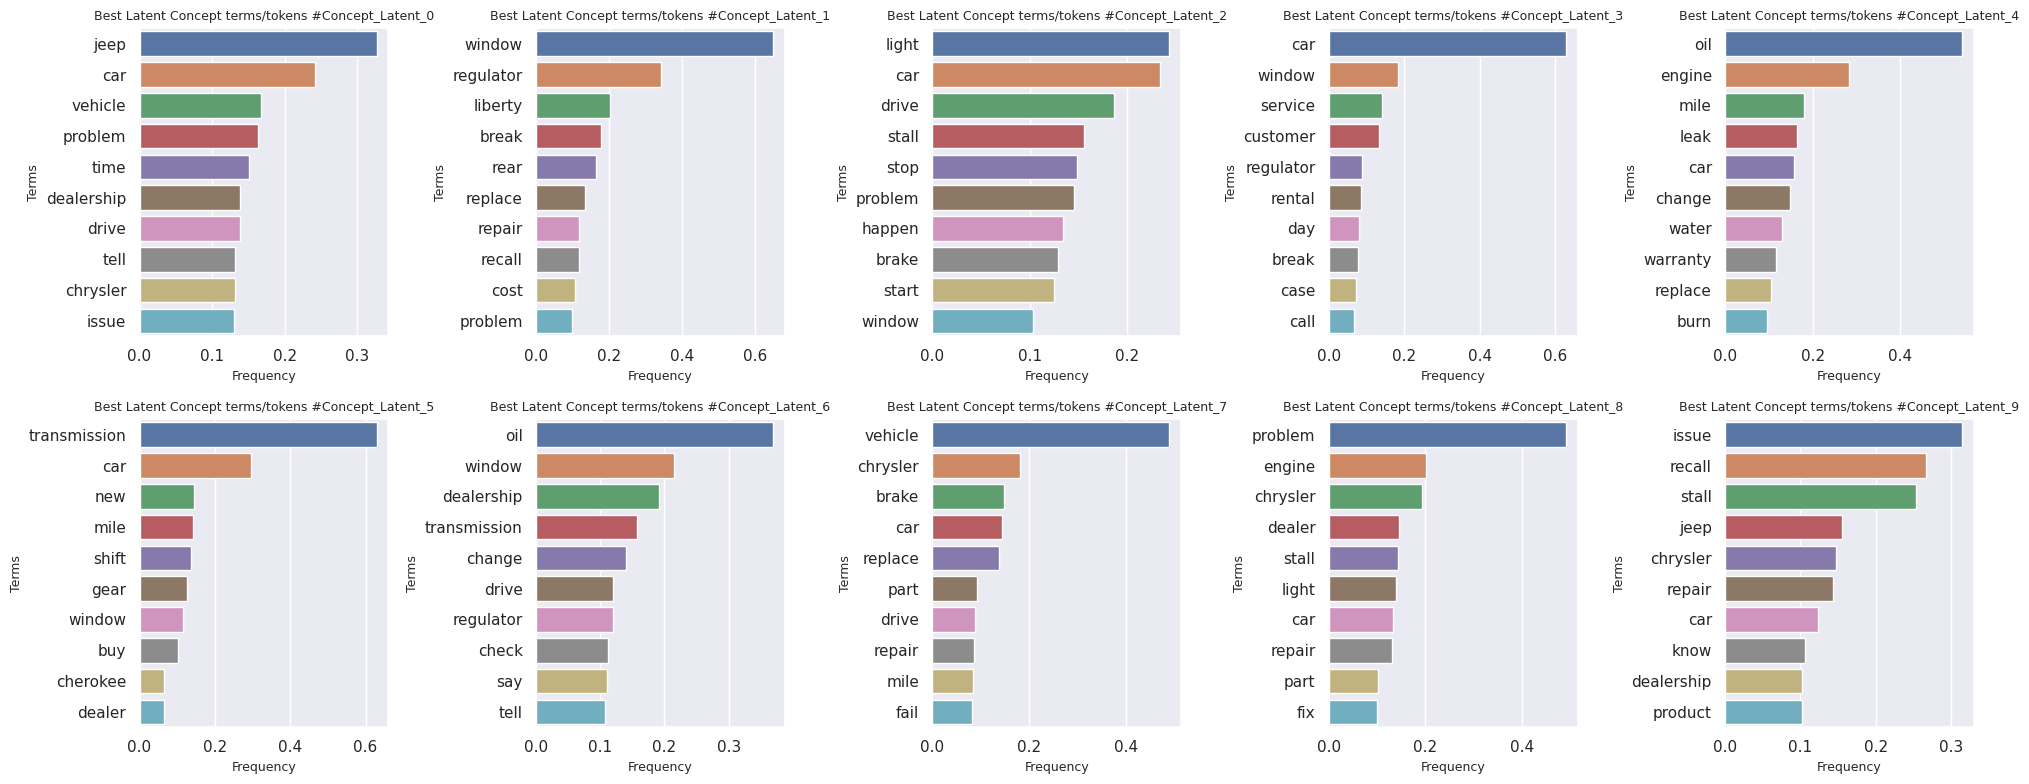

In [ ]:
print('Negative Comment')
plot_grouped_top_terms(term_topic_matrix_label_0)

Positive Comments


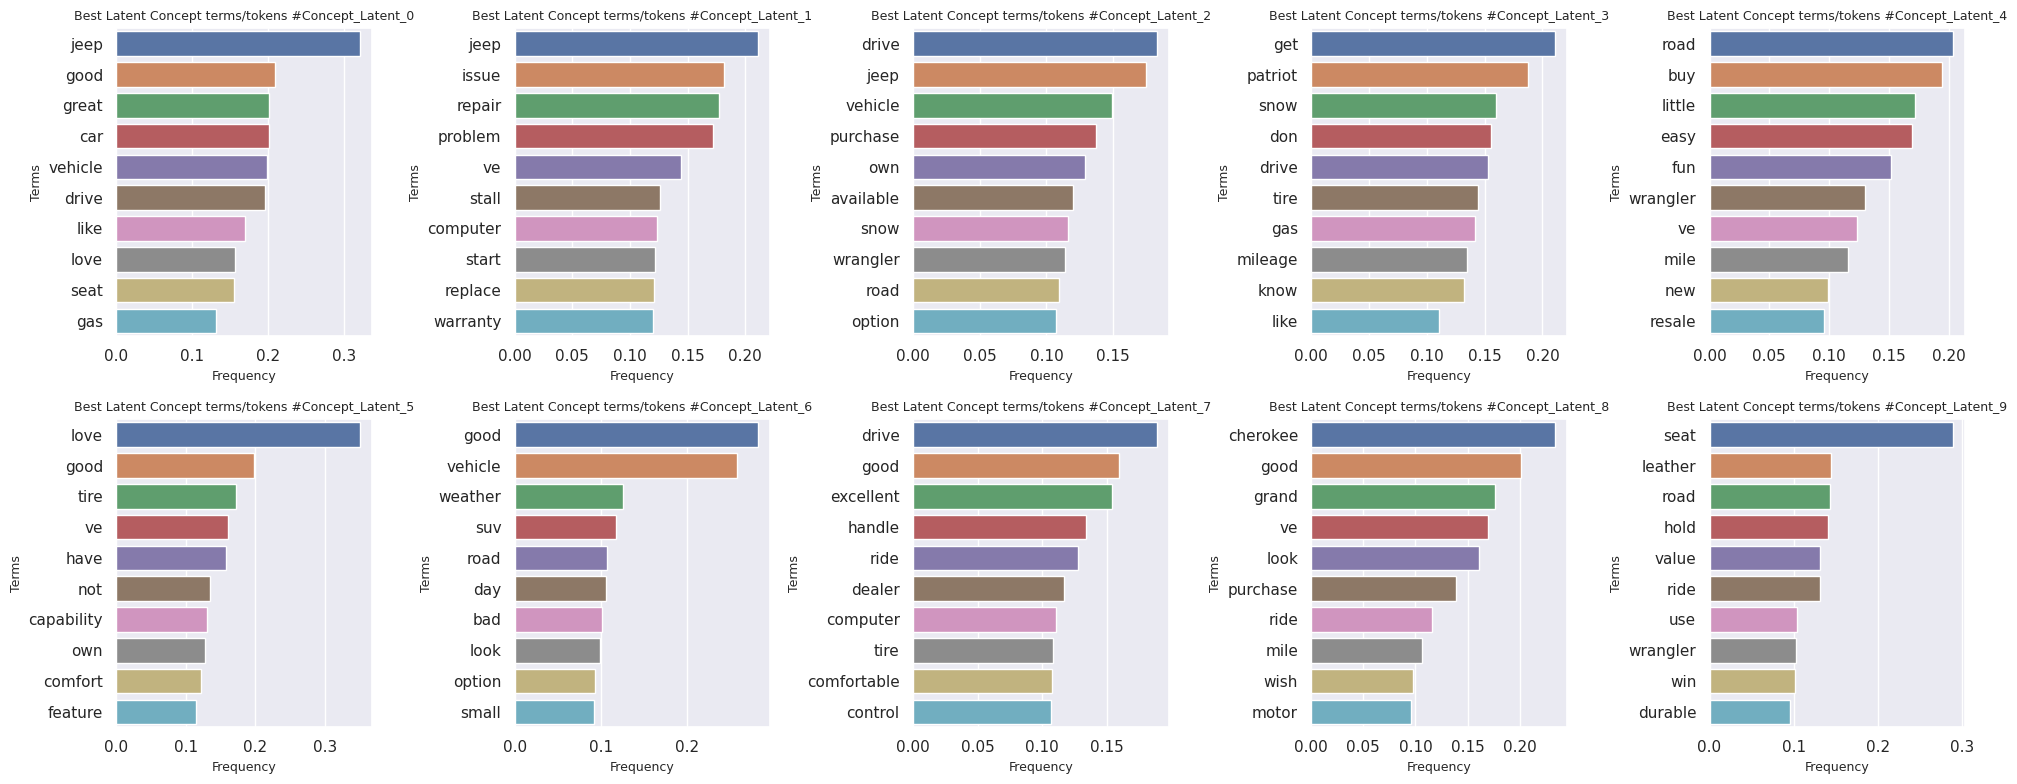

In [ ]:
print('Positive Comments')
plot_grouped_top_terms(term_topic_matrix_label_1)

### **LSI (Latent Semantic Indexing) method using Gensim**

Latent Semantic Indexing (LSI) using Gensim is a technique for analyzing and discovering hidden semantic structures in a collection of texts. Gensim is a popular Python library for topic modeling, document similarity analysis, and other natural language processing tasks.

LSI using Gensim is commonly used for tasks such as document clustering, information retrieval, and topic modeling. It provides a way to uncover hidden relationships and patterns in text data, enabling better understanding and organization of large document collections.

#### **Dictionary creation with Gensim**

In [ ]:
doc_dict_label_0 = corpora.Dictionary(tokens_label_0) #Create dictionary of negative comments

doc_dict_label_1 = corpora.Dictionary(tokens_label_1) #Create dictionary of positive comments

#### **Bag of Words (BOW) creation**

In [ ]:
bow_label_0 = [doc_dict_label_0.doc2bow(doc) for doc in tokens_label_0]
bow_label_1 = [doc_dict_label_1.doc2bow(doc) for doc in tokens_label_1]

#### **Calculation of the coherence of LSI (Latent Semantic Indexing) models with different numbers of topics (topics)**

In [ ]:
# Function to calculate lsi coherence.
def calculate_lsi_coherence(bow, doc_dict, tokens):
    metrics = []
    for i in range(2, 11): #initiation is 2 because is a number minimu
        lsi = LsiModel(bow, num_topics=i, id2word=doc_dict, chunksize=len(tokens), random_seed=42)
        cm = CoherenceModel(model=lsi, texts=tokens, dictionary=doc_dict, window_size=3, coherence='c_v', topn=3)
        metrics.append([i, cm.get_coherence()])
    return metrics

**Note:** Starting  the ford at 2 makes sense because it is the minimum reasonable number of topics that could be expected to be found in a corpus. Ending at 10 is an arbitrary choice and may vary depending on the specific analysis and data set.

In [ ]:
metrics_label_0= calculate_lsi_coherence(bow_label_0, doc_dict_label_0, tokens_label_0)
metrics_label_1= calculate_lsi_coherence(bow_label_1, doc_dict_label_1, tokens_label_1)

#### **Negative comments Topics and Metrics**

In [ ]:
df_metrics_label_0 = pd.DataFrame(data= metrics_label_0, columns = ['Topics', 'Metrics'])
df_metrics_label_0

,Topics,Metrics
0,2,0.440884
1,3,0.436888
2,4,0.465112
3,5,0.477101
4,6,0.472262
5,7,0.482104
6,8,0.504931
7,9,0.467699
8,10,0.517325


#### **Positive comments Topics and Metrics**

In [ ]:
df_metrics_label_1 = pd.DataFrame(data= metrics_label_1, columns = ['Topics', 'Metrics'])
df_metrics_label_1

,Topics,Metrics
0,2,0.283365
1,3,0.356525
2,4,0.337152
3,5,0.324270
4,6,0.462076
5,7,0.456960
6,8,0.422841
7,9,0.396681
8,10,0.442253


#### **Best number of Topics.**

In [ ]:
best_num_topics_label_0 = df_metrics_label_0[df_metrics_label_0['Metrics'] == df_metrics_label_0['Metrics'].max()]['Topics'].values[0]
print(f'best number of Topics in negative comments: {best_num_topics_label_0}')

best number of Topics in negative comments: 10


In [ ]:
best_num_topics_label_1 = df_metrics_label_1[df_metrics_label_1['Metrics'] == df_metrics_label_1['Metrics'].max()]['Topics'].values[0]
print(f'best number of Topics in postivie comments: {best_num_topics_label_1}')

best number of Topics in postivie comments: 6


#### **Visualization of Tokens/Word in Topic**

In [ ]:
def print_topic_distribution(bow, best_num_topics, doc_dict,tokens, num_words=10):
  lsi = LsiModel(bow,
                num_topics=best_num_topics,
                id2word=doc_dict,
                chunksize=len(tokens),
                random_seed=7
                )

  #print_topic_distribution(lsi)
  for topic_num, words in lsi.print_topics(num_words=num_words):
       print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))


In [ ]:
print("Negative Comments:")
print_topic_distribution(bow_label_0,best_num_topics_label_0, doc_dict_label_0,tokens_label_0, num_words=10)

Negative Comments:
Tokens/Words in Topic 0: 0.556*"jeep" + 0.284*"car" + 0.212*"vehicle" + 0.167*"dealership" + 0.167*"drive" + 0.165*"tell" + 0.153*"time" + 0.152*"issue" + 0.149*"service" + 0.143*"problem".
Tokens/Words in Topic 1: -0.677*"car" + 0.596*"jeep" + -0.160*"drive" + -0.107*"come" + -0.099*"light" + 0.083*"vehicle" + -0.075*"day" + -0.072*"start" + -0.070*"work" + -0.065*"seat".
Tokens/Words in Topic 2: -0.437*"car" + 0.376*"vehicle" + -0.290*"jeep" + 0.238*"issue" + 0.230*"seat" + 0.195*"service" + 0.181*"call" + 0.160*"dealership" + 0.130*"day" + -0.125*"fix".
Tokens/Words in Topic 3: -0.520*"vehicle" + -0.349*"chrysler" + 0.348*"jeep" + -0.263*"problem" + 0.165*"seat" + 0.159*"service" + -0.138*"new" + -0.137*"dealer" + 0.121*"issue" + -0.112*"mile".
Tokens/Words in Topic 4: 0.300*"tell" + -0.291*"drive" + 0.255*"dealership" + 0.251*"service" + 0.250*"customer" + 0.245*"chrysler" + -0.201*"problem" + -0.189*"start" + 0.153*"warranty" + 0.149*"car".
Tokens/Words in Topic

In [ ]:
print("Positive Comments:")
print_topic_distribution(bow_label_1,best_num_topics_label_1, doc_dict_label_1,tokens_label_1, num_words=12)

Positive Comments:
Tokens/Words in Topic 0: -0.622*"jeep" + -0.238*"vehicle" + -0.226*"car" + -0.217*"drive" + -0.203*"great" + -0.176*"like" + -0.170*"good" + -0.147*"love" + -0.143*"seat" + -0.126*"gas" + -0.109*"cherokee" + -0.105*"get".
Tokens/Words in Topic 1: -0.491*"car" + 0.479*"jeep" + -0.250*"good" + -0.241*"gas" + -0.212*"seat" + -0.185*"great" + -0.144*"time" + -0.138*"tank" + -0.118*"fill" + 0.104*"vehicle" + -0.102*"shut" + 0.092*"ve".
Tokens/Words in Topic 2: -0.305*"vehicle" + -0.296*"drive" + 0.293*"jeep" + 0.277*"car" + -0.237*"good" + -0.210*"like" + 0.173*"time" + 0.158*"gas" + 0.139*"tank" + 0.133*"shut" + -0.132*"wheel" + 0.131*"issue".
Tokens/Words in Topic 3: 0.540*"vehicle" + -0.197*"like" + 0.175*"stop" + 0.160*"mpg" + 0.148*"gas" + 0.146*"time" + -0.133*"love" + -0.131*"good" + 0.130*"brake" + -0.126*"jeep" + -0.124*"buy" + 0.117*"shut".
Tokens/Words in Topic 4: 0.346*"drive" + 0.326*"gas" + -0.321*"car" + 0.203*"wheel" + -0.191*"great" + -0.184*"good" + 0.17

## **LDA (Latent Dirichlet Allocation)**

Latent Dirichlet Allocation, which is a generative probabilistic model used for topic modeling. In the context of natural language processing (NLP), LDA is a technique that helps discover latent topics within a collection of documents.

- Document-Topic and Topic-Word Distributions: LDA assumes that each document is a mixture of a small number of topics and that each word in the document is attributable to one of the document's topics. It also assumes that each topic is a distribution over words.

- Model Training: LDA takes a collection of documents as input and iteratively assigns words to topics and topics to documents, updating the topic-word and document-topic distributions until convergence. This process involves probabilistic inference to estimate the most likely topic assignments for each word in each document.

- Topic Interpretation: Once the model is trained, each document is associated with a distribution over topics, and each topic is associated with a distribution over words. These distributions can be interpreted to understand the main themes present in the corpus and how words are associated with different topics.

## **LDA training models in parallels using multiple CPU and Coherence scores calculation**

In [ ]:
#function to calculate coherence

def calculate_lda_coherence(bow, doc_dict, tokens):
    n_cores = cpu_count()
    metrics = []
    for i in range(2, 11):
        lda = LdaMulticore(
            corpus=bow, #The bag-of-words representation of the corpus.
            id2word=doc_dict, #The Gensim dictionary mapping token IDs to words.
            num_topics=i, # The number of topics to extract.
            chunksize=len(tokens), #The number of documents to process in each training chunk.
            passes=10, #The number of passes through the corpus during training.
            alpha=0.2, #The hyperparameter controlling the document-topic density.
            eta=0.2, #The hyperparameter controlling the topic-word density.
            workers=n_cores - 1,# The number of worker threads to use for parallel training (one less than the total CPU cores to leave one core for other tasks).
            random_state=42
        )
        cm = CoherenceModel(model=lda, texts=tokens, dictionary=doc_dict, window_size=3, coherence='c_v', topn=3)
        metrics.append([i, cm.get_coherence()])
    return metrics

**Note:**
- Starting  the ford at 2 makes sense because it is the minimum reasonable number of topics that could be expected to be found in a corpus. Ending at 10 is an arbitrary choice and may vary depending on the specific analysis and data set.

- The consistency metric provides a measure of how interpretable the topics generated by the LDA model are.

- The higher the value of the coherence metric, the more coherent and distinctive the topics are, indicating better quality of the model in terms of the ability to extract meaningful and well-defined topics from the data.

### **Negative Comments lda topics Coherence calculation.**

In [ ]:
lda_metrics_label_0=calculate_lda_coherence(bow_label_0, doc_dict_label_0, tokens_label_0)

In [ ]:
df_lda_metrics_label_0 = pd.DataFrame(data= lda_metrics_label_0, columns = ['Topics', 'Metrics'])
df_lda_metrics_label_0

,Topics,Metrics
0,2,0.377791
1,3,0.449552
2,4,0.463969
3,5,0.420276
4,6,0.430359
5,7,0.475974
6,8,0.458611
7,9,0.469003
8,10,0.441665


### **Positive Comments lda topics Coherence calculation.**

In [ ]:
lda_metrics_label_1=calculate_lda_coherence(bow_label_1, doc_dict_label_1, tokens_label_1)

In [ ]:
df_lda_metrics_label_1 = pd.DataFrame(data= lda_metrics_label_1, columns = ['Topics', 'Metrics'])
df_lda_metrics_label_1

,Topics,Metrics
0,2,0.485303
1,3,0.510309
2,4,0.507082
3,5,0.459400
4,6,0.460094
5,7,0.459412
6,8,0.496557
7,9,0.451388
8,10,0.480696


### **Best number of LDA Topics calculation.**

In [ ]:
best_num_topics_lda_label_0 = df_lda_metrics_label_0[df_lda_metrics_label_0['Metrics'] == df_lda_metrics_label_0['Metrics'].max()]['Topics'].values[0]
print(f'Best number of Topics in negative comments: {best_num_topics_lda_label_0}')

best number of Topics in negative comments: 7


In [ ]:
best_num_topics_lda_label_1 = df_lda_metrics_label_1[df_lda_metrics_label_1['Metrics'] == df_lda_metrics_label_1['Metrics'].max()]['Topics'].values[0]
print(f'best number of Topics in postivie comments: {best_num_topics_lda_label_1}')

best number of Topics in postivie comments: 3


### **Visualization of LDA topics**

In [ ]:
def train_lda_model(bow, doc_dict, tokens, best_num_topics):
    n_cores = cpu_count()
    lda = LdaMulticore(
        corpus=bow,
        id2word=doc_dict,
        num_topics=best_num_topics, # The number of topics to extract.
        chunksize=len(tokens), #The number of documents to process in each training chunk.
        passes=10, #The number of passes through the corpus during training.
        alpha=0.2, #The hyperparameter controlling the document-topic density.
        eta=0.2, #The hyperparameter controlling the topic-word density.
        workers=n_cores - 1,
        random_state=42)
    for topic_num, words in lda.print_topics(num_words=5):
      print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))
    return lda

#### **LDA for Negative comments:**

In [ ]:
print('Negative Comments')
lda_label_0=train_lda_model(bow_label_0,doc_dict_label_0,tokens_label_0,best_num_topics_lda_label_0)

Negative Comments
Tokens/Words in Topic 0: 0.020*"jeep" + 0.013*"dealership" + 0.010*"service" + 0.009*"tell" + 0.009*"vehicle".
Tokens/Words in Topic 1: 0.037*"jeep" + 0.027*"car" + 0.014*"customer" + 0.012*"dealership" + 0.011*"buy".
Tokens/Words in Topic 2: 0.029*"jeep" + 0.020*"car" + 0.015*"drive" + 0.012*"vehicle" + 0.012*"problem".
Tokens/Words in Topic 3: 0.046*"jeep" + 0.017*"car" + 0.014*"time" + 0.012*"issue" + 0.012*"vehicle".
Tokens/Words in Topic 4: 0.027*"jeep" + 0.015*"vehicle" + 0.013*"transmission" + 0.007*"car" + 0.007*"service".
Tokens/Words in Topic 5: 0.018*"jeep" + 0.017*"car" + 0.013*"problem" + 0.009*"window" + 0.008*"drive".
Tokens/Words in Topic 6: 0.034*"jeep" + 0.018*"vehicle" + 0.014*"chrysler" + 0.011*"warranty" + 0.010*"engine".


#### **LDA for positive comments:**

In [ ]:
print('Positive Comments')
lda_label_1=train_lda_model(bow_label_1,doc_dict_label_1,tokens_label_1,best_num_topics_lda_label_1)

Positive Comments
Tokens/Words in Topic 0: 0.025*"car" + 0.025*"jeep" + 0.018*"good" + 0.014*"vehicle" + 0.013*"like".
Tokens/Words in Topic 1: 0.045*"jeep" + 0.021*"vehicle" + 0.021*"drive" + 0.014*"great" + 0.013*"like".
Tokens/Words in Topic 2: 0.044*"jeep" + 0.016*"car" + 0.016*"love" + 0.014*"gas" + 0.013*"great".


### **Visualization with PyLDAvis**

In PyLDAvis, the parameter "lambda" (often abbreviated as "λ") controls the relative importance of words in the topic visualization. More specifically, lambda controls the relevance of words based on their contribution to the distinctiveness of the topic.

When adjusting the lambda value in PyLDAvis, you are weighting the words in the topics based on two main factors:

Term Relevance: Words are ranked within topics based on their probability of appearing in the topic and their relative frequency in the overall corpus. The higher this probability, the more likely the word is associated with the topic. (**High Lambda**)

Term Exclusivity: Words that are common across multiple topics are penalized. This is done by weighting the word by the probability of it appearing in other topics. The lower the probability of the word appearing in other topics, the more exclusive it will be considered in the current topic. (**Low Lambda**)

The default value of lambda in PyLDAvis is 0.6. By adjusting this value, you can change the relative importance of the two factors mentioned above. For example, increasing the lambda value will give more weight to term exclusivity over term relevance, resulting in more exclusive words in the topics. Conversely, decreasing the lambda value will give more weight to term relevance, allowing more common words to appear in the topics.

#### **PyLDAvis with negative comments.**

In [ ]:
#pyLDAvis.enable_notebook()
vis_data_label_0 = gensimvis.prepare(lda_label_0, bow_label_0, doc_dict_label_0)
pyLDAvis.save_html(vis_data_label_0, '/content/lda_negative_comments_result.html')
display(HTML('/content/lda_negative_comments_result.html'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: Deprecat

#### **PyLDAvis with positive comments.**

In [ ]:
#pyLDAvis.enable_notebook()
vis_data_label_1 = gensimvis.prepare(lda_label_1, bow_label_1, doc_dict_label_1)
pyLDAvis.save_html(vis_data_label_1, '/content/lda_positive_comments_result.html')
display(HTML('/content/lda_positive_comments_result.html'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: Deprecat

# **Conclusions:**


The choice between LDA (Latent Dirichlet Allocation) and LSI (Latent Semantic Indexing) for topic extraction depends on several factors, including the specific characteristics of the dataset and the objectives of the analysis. Here are some considerations to help you decide:

Interpretation of Topics:

- LDA: It is known for its ability to generate interpretable topics. Since LDA models each document as a mixture of topics, the resulting topics are often more coherent and easier to interpret.
LSI: Topics in LSI are based on linear combinations of terms and may be less intuitive to interpret, as they are not specifically designed to represent topics in the conventional sense.
Model Flexibility:

- LDA: It is a probabilistic generative model, meaning it assumes an underlying structure in document generation. This can provide greater flexibility and the ability to capture the complexity of the data.
LSI: It is a simpler technique than LDA and does not assume a specific probabilistic structure in document generation. This may be an advantage in situations where simplicity is preferred or where the data does not strictly follow a generative model.
Scalability:

LDA: Some implementations of LDA, such as LdaMulticore in Gensim, are efficient and scalable, allowing them to handle large datasets.
LSI: It may have scalability issues with large datasets due to the need to compute term-document matrices.
Empirical Performance:

In general, LDA tends to perform better in topic extraction compared to LSI, especially when dealing with text data. This is due to the generative nature of LDA and its better ability to model the word distribution in documents.
In summary, if topic interpretation is a priority and you have the computational capability to handle a more complex probabilistic model, LDA may be preferable. However, if you're looking for a simpler and more efficient technique for feature extraction, especially on smaller datasets, LSI could be a suitable option.

Based on this characteristics and results observed LDA shows better results.

# **References:**

- KeepCoding. (s.f.). ¿Qué es el topic modeling?. https://keepcoding.io/blog/que-es-el-topic-modeling/#:~:text=El%20topic%20modeling%20es%20un,los%20que%20se%20est%C3%A1%20hablando.

- Amat,J.(2016). Análisis discriminante lineal (LDA) y análisis discriminante cuadrático (QDA). cienciadedatos.net. https://www.cienciadedatos.net/documentos/28_linear_discriminant_analysis_lda_y_quadratic_discriminant_analysis_qda

- BIMsoluciones. (2021, July 21). Que es Indexación semántica latente o LSI. https://bimsoluciones.com/indexacion-semantica/

- Vajjala, S., Majumder, B., Gupta, A., y Surana, H. (2020). Practical Natural Language Processing: A Comprehensive Guide to Building Real-World NLP Systems. O'Reilly

- Falcón Morales, L. E. (2023). Modelado de Temas: LSI [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM.

- Falcón Morales, L. E. (2023). Modelado_de_Temas_LDA [PDF]. Maestría en Inteligencia Artificial Aplicada. ITESM

- Interactive Chaos. (s. f.). Descomposición en valores singulares (SVD). Recuperado de https://interactivechaos.com/es/wiki/descomposicion-en-valores-singulares-svd#:~:text=La%20Descomposici%C3%B3n%20en%20Valores%20Singulares,matriz%20en%20sus%20partes%20constituyentes.

- Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3, 993–1022.

- Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by Latent Semantic Analysis. Journal of the American Society for Information Science, 41(6), 391–407.